# Derivative with respect to flight parameters
In this notebook we assume the flight path is parameterized. To optimize the flight path, we'll probably need the gradient of the utility with respect to these parameters. Since this envolves matrix dervatives, which introduce a lot of potential for error, we start in this notebook with the simple case: One parameter for the inverse problem, one parameter for the flight path, time-independent setting.

In [1]:
import sys
sys.path.insert(0, "../source/")

from FOM_advectiondiffusion import FOM_advectiondiffusion
from FOM_advectiondiffusion_steadystate import FOM_advectiondiffusion_steadystate
from Drone import Drone
from Parameter import Parameter
from Brain import Brain
from NoiseModel import NoiseModel
from Prior import Prior

import dolfin as dl
import matplotlib.pyplot as plt
import numpy as np
import time
import scipy.linalg as la
import scipy.sparse as sparse
import scipy.sparse.linalg as sla
import math
import scipy.stats as stats

In [2]:
tStart_notebook = time.time()

## User settings

In [3]:
meshDim = 100
# meshDim=50 is probably too coarse but for writing the code it should suffice, I'm impatient

n_para = 1
n_search = 30

eval_mode = "point-eval" # because it's faster for testing code

dt = 0.001

## Setup

In [4]:
fom = FOM_advectiondiffusion_steadystate(meshDim=meshDim)
grid_t = np.arange(0, 1+dt, dt)

para_true = np.ones((n_para,))
m = fom.assemble_forcing(para=para_true)
sol_steadystate = fom.solve_steady(forcing=m)

# set default flying parameters
flying_parameters = {
                "radius" : 0.25,
                "center" : np.array([0.75/2, 0.55/2]),
                "speed" : 0.2 # 0.3
            }

drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)

prior = Prior(covar = np.eye(n_para), mean = np.zeros((n_para,)))
noise_model = NoiseModel(grid_t=grid_t, c_scaling=1e+3, c_diffusion = 0.01)
brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)

## Derivative of the posterior covariance matrix (w.r.t. speed)

Let's take the derivative with respect to the speed. We saw in the previous notebook that the utility function doesn't look too boring in this case, so it should give us lots of interesting points for double-checking.

In [5]:
def d_position_d_speed(t, flying_parameters = flying_parameters):
    
    radius = flying_parameters["radius"]
    speed = flying_parameters["speed"]

    round_trip_time = 2 * np.pi * radius / speed
    angles = (t * 2 * np.pi) / round_trip_time
    pos = t * np.hstack([-np.sin(angles), np.cos(angles)]).T 
    
    return pos

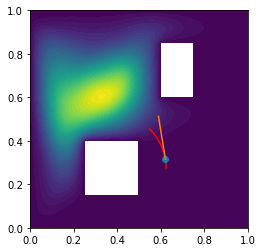

In [6]:
t = 0.2
der = d_position_d_speed(t = t)

dl.plot(sol_steadystate, mesh=fom.mesh)
plt.plot(pos[:, 0], pos[:, 1], color="r")

k = np.argmin(np.abs(grid_t - t))

plt.plot([pos[k, 0]], [pos[k, 1]], marker = "o")

plt.plot([pos[k, 0], pos[k, 0] + 1 * der[0]], [pos[k, 1], pos[k, 1] +1 * der[1]])

For point evaluations we have 
$$
\frac{d}{d\alpha} u(p(t, \alpha)) = Du(p(t, \alpha)) \nabla p(t, \alpha)
$$

In [7]:
Du = dl.grad(sol_steadystate)
Du = dl.project(Du)

def d_measurement_d_speed(t, flying_parameters = flying_parameters):
    
    position = drone.get_position(t=t, flying_parameters = flying_parameters)
    grad_p = d_position_d_speed(t=t, flying_parameters = flying_parameters)
    
    if eval_mode == "point-eval":
        Du_at_position = Du(position)
        
    return Du_at_position @ grad_p

Text(0, 0.5, 'measured value')

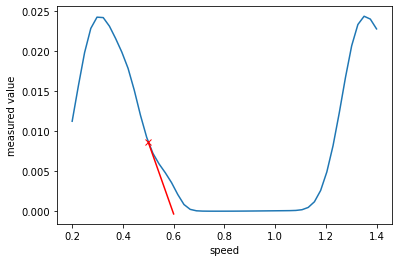

In [8]:
t = 1.5
speed_test = 0.5
n_test = 50

vec_speed = np.linspace(0.2, 1.4, n_test)
pos_test = np.zeros((n_test, 2))
for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = vec_speed[i]
    
    pos_test[i, :] = drone.get_position(t=t, flying_parameters=flying_parameters_2)
    
# dl.plot(sol_steadystate, mesh=fom.mesh)
# plt.plot(pos_test[:, 0], pos_test[:, 1], color="r")

measurements = drone.measure(flightpath=pos_test, state=sol_steadystate)
# note: this only works this way for steady-state - in the transient case we need to pass the state at time t

flying_parameters_2 = flying_parameters.copy()
flying_parameters_2["speed"] = speed_test
d_test = d_measurement_d_speed(t=t, flying_parameters=flying_parameters_2)
position = drone.get_position(t=t, flying_parameters=flying_parameters_2)
val = drone.measure(flightpath = np.array([position]), state = sol_steadystate)

fig, ax = plt.subplots(1,1)

ax.plot(vec_speed, measurements)
ax.plot([speed_test, speed_test + 0.1], [val, val + 0.1 * d_test], color = "red")
ax.plot([speed_test], [val], marker = "x", color = "red")

ax.set_xlabel("speed")
ax.set_ylabel("measured value")

Next we evaluate the derivative of the inverse covariance matrix.

In [9]:
def d_invPostCov_d_speed(flying_parameters=flying_parameters):
    
    drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
    pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)
    BU = drone.measure(flightpath = pos, state=sol_steadystate)
    
    dBU = np.zeros(BU.shape)
    for k in range(dBU.shape[0]):
        dBU[k] = d_measurement_d_speed(t=grid_t[k], flying_parameters=flying_parameters)
        
    invCovBU = noise_model.apply_covar_inv(BU)
    # todo: double-check that this doesn't apply BU also from the left
    
    return dBU.T @ invCovBU + invCovBU.T @ dBU

In [10]:
n_test = 100

vec_speed = np.linspace(0.2, 1.4, n_test)
val_test = np.zeros((n_test,))

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = vec_speed[i]

    drone_2 = Drone(fom, flying_parameters=flying_parameters_2, eval_mode=eval_mode, grid_t=grid_t)
    brain_2 = Brain(fom=fom, drone=drone_2, prior=prior, noise_model=noise_model)
    post_2 = brain_2.compute_posterior()
    val_test[i] = post_2.covar_inv

Text(0, 0.5, 'inverse posterior covariance')

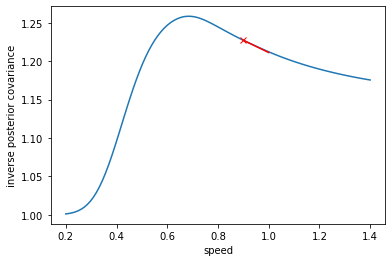

In [11]:
speed_test = 0.9
flying_parameters_2 = flying_parameters.copy()
flying_parameters_2["speed"] = speed_test

drone_2 = Drone(fom, flying_parameters=flying_parameters_2, eval_mode=eval_mode, grid_t=grid_t)
brain_2 = Brain(fom=fom, drone=drone_2, prior=prior, noise_model=noise_model)
post_2 = brain_2.compute_posterior()
val = post_2.covar_inv[0, 0]

d_val = d_invPostCov_d_speed(flying_parameters=flying_parameters_2)


fig, ax = plt.subplots(1,1)

ax.plot(vec_speed, val_test)
ax.plot([speed_test, speed_test + 0.1], [val, val + 0.1 * d_val], color = "red")
ax.plot([speed_test], [val], marker = "x", color = "red")

ax.set_xlabel("speed")
ax.set_ylabel("inverse posterior covariance")

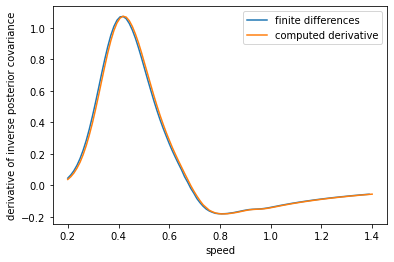

In [12]:
d_test = np.zeros((n_test,))
for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = vec_speed[i]
    d_test[i] = d_invPostCov_d_speed(flying_parameters=flying_parameters_2)

fig, ax = plt.subplots(1,1)

ax.plot(vec_speed[:-1], (val_test[1:]-val_test[:-1])/(vec_speed[1]-vec_speed[0]), label = 'finite differences')
ax.plot(vec_speed, d_test, label = 'computed derivative')

ax.set_xlabel("speed")
ax.set_ylabel("derivative of inverse posterior covariance")
ax.legend()

In [13]:
def d_PostCov_d_speed(flying_parameters=flying_parameters, bool_return_both = True):
    
    drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
    pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)
    BU = drone.measure(flightpath = pos, state=sol_steadystate)
    invCovBU = noise_model.apply_covar_inv(BU)
    invPostCov = BU.T @ invCovBU + prior.covar_inv
    
    # sanity check, comment out for better performance
#     brain = Brain(fom=fom, drone=drone, prior=prior, noise_model=noise_model)
#     post = brain.compute_posterior()
#     test = post.covar_inv
#     print("Sanity check:", np.isclose(invPostCov, test).all())
    
    # get derivative of inverse posterior covariance matrix
    yolo = d_invPostCov_d_speed(flying_parameters=flying_parameters)
    if len(yolo.shape) == 0:
        yolo = np.array(np.array([yolo]))
    # todo: the call to d_invPostCov_d_speed re-computes a lot of parts that are already computed here,
    #  i.e., it's redundant. I keep it here for easier debugging - if it turns out that there's an error above
    #  I won't need to change it in two places. When we put this into the source code we should optimize this call
    # out though
    
    PostCov = la.inv(invPostCov)
    derivative = -PostCov @ yolo @ PostCov
    # todo: I'm using la.inv here because I also want to return the matrix below. However, when we adapt this
    # into the source code we need to replace it with a proper linear system solve
    
    if bool_return_both:
        # todo: the return here of the posterior covariance is only for faster comparison in the plots below
        # in practice we should NOT compute it, especially not using la.inv
        return derivative, PostCov
    
    return derivative

In [14]:
val_test_2 = np.zeros((n_test,))
d_test_2 = np.zeros((n_test,))

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = vec_speed[i]
    d_test_2[i], val_test_2[i] = d_PostCov_d_speed(flying_parameters=flying_parameters_2)
    
print("Sanity check: ", np.isclose(val_test * val_test_2, np.ones((n_test,))).all())

Sanity check:  True


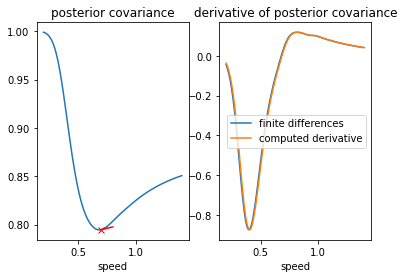

In [15]:
speed_test = 0.7
flying_parameters_2 = flying_parameters.copy()
flying_parameters_2["speed"] = speed_test
d_val, val = d_PostCov_d_speed(flying_parameters=flying_parameters_2)
d_val = d_val[0]
val = val[0,0]

fig, axs = plt.subplots(1,2)

axs[0].plot(vec_speed, val_test_2)
axs[0].plot([speed_test, speed_test + 0.1], [val, val + 0.1 * d_val], color = "red")
axs[0].plot([speed_test], [val], marker = "x", color = "red")

axs[0].set_xlabel("speed")
axs[0].set_title("posterior covariance")

axs[1].plot(vec_speed[:-1], (val_test_2[1:]-val_test_2[:-1])/(vec_speed[1]-vec_speed[0]), label = 'finite differences')
axs[1].plot(vec_speed, d_test_2, label = 'computed derivative')

axs[1].set_xlabel("speed")
axs[1].set_title("derivative of posterior covariance")
axs[1].legend()

Next are the A- and D-OED utility functions, i.e. the matrix trace and matrix determinant. The trace is easier.

(Well, for one parameter dimension they are both simple and the computations below are completely redundant and overkill, but it's good to have them figured out before going to more parameter dimensions.)

In [16]:
def d_utilA_d_speed(flying_parameters=flying_parameters, bool_return_covar = True):
    der, postCov = d_PostCov_d_speed(flying_parameters=flying_parameters, bool_return_both = True)
    
    if len(der) == 1:
        der = np.array([der])
    
    if bool_return_covar:
        return np.trace(der), postCov
    
    return np.trace(der)

In [17]:
val_test_3 = np.zeros((n_test,))
d_test_3 = np.zeros((n_test,))

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = vec_speed[i]
    d_test_3[i], yolo = d_utilA_d_speed(flying_parameters=flying_parameters_2)
    val_test_3[i] = np.trace(yolo)
    
print("Sanity check:", np.isclose(val_test_3, val_test_2).all())
print("Sanity check:", np.isclose(d_test_3, d_test_2).all())

Sanity check: True
Sanity check: True


I'm not making individual plots for the utility functions - since we have only one parameter dimensions, they would be exactly the same as the previous plots. 

In [18]:
def d_utilD_d_speed(flying_parameters=flying_parameters, bool_return_covar = True):
    der, postCov = d_PostCov_d_speed(flying_parameters=flying_parameters, bool_return_both = True)
    
    if len(der) == 1:
        der = np.array([der])
        
    # apply transposed cofactor matrix 
    det = la.det(postCov)
    yolo = det * la.solve(postCov.T, der)
    # todo: the decomposition cofactor(M) = det(M)*inv(M) only holds for invertible matrices M
    # I don't think the posterior covariance matrix can become singular unless the prior or the noise covariance
    # matrices are degenerate. We might want to catch that case though.
        
    if bool_return_covar:
        return np.trace(yolo), postCov
    
    return np.trace(yolo)

In [19]:
val_test_4 = np.zeros((n_test,))
d_test_4 = np.zeros((n_test,))

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["speed"] = vec_speed[i]
    d_test_4[i], yolo = d_utilD_d_speed(flying_parameters=flying_parameters_2)
    val_test_4[i] = la.det(yolo)
    
print("Sanity check:", np.isclose(val_test_4, val_test_2).all())
print("Sanity check:", np.isclose(d_test_4, d_test_2).all())

Sanity check: True
Sanity check: True


## Derivative of the posterior covariance matrix (w.r.t. radius)

For the derivative with respect to the radius I'm only repeating the first steps, not the matrix derivatives. It's only one function that changes really (the derivative of the position), everything else is exactly the same. I'm only repeating some of the functions here for double-checking.

In [20]:
def d_position_d_radius(t, flying_parameters = flying_parameters):
    
    radius = flying_parameters["radius"]
    speed = flying_parameters["speed"]
    
    round_trip_time = 2 * np.pi * radius / speed
    angles = (t * 2 * np.pi) / round_trip_time
    pos = np.hstack([np.cos(angles), np.sin(angles)]).T 
    pos = pos - (t * speed) * np.hstack([-np.sin(angles), np.cos(angles)]).T / radius
    
    return pos

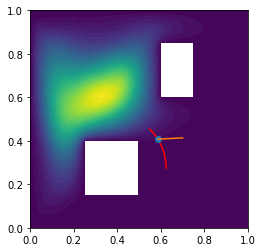

In [21]:
t = 0.7
der = d_position_d_radius(t = t)

dl.plot(sol_steadystate, mesh=fom.mesh)
plt.plot(pos[:, 0], pos[:, 1], color="r")

k = np.argmin(np.abs(grid_t - t))

plt.plot([pos[k, 0]], [pos[k, 1]], marker = "o")

plt.plot([pos[k, 0], pos[k, 0] + 0.1 * der[0]], [pos[k, 1], pos[k, 1] + 0.1 * der[1]])

In [22]:
Du = dl.grad(sol_steadystate)
Du = dl.project(Du)

def d_measurement_d_radius(t, flying_parameters = flying_parameters):
    
    position = drone.get_position(t=t, flying_parameters = flying_parameters)
    grad_p = d_position_d_radius(t=t, flying_parameters = flying_parameters)
    
    if eval_mode == "point-eval":
        Du_at_position = Du(position)
        
    return Du_at_position @ grad_p

Text(0, 0.5, 'measured value')

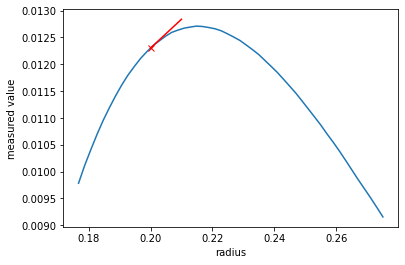

In [23]:
t = 1.5
radius_test = 0.2
n_test = 50

radius_min = la.norm(np.array([0.75, 0.55])/2 - np.array([0.5, 0.4])) # 0.1767
radius_max = la.norm(np.array([0, 0.55])/2) # 0.275
vec_radius = np.linspace(radius_min, radius_max, n_test)

pos_test = np.zeros((n_test, 2))
for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["radius"] = vec_radius[i]
    
    pos_test[i, :] = drone.get_position(t=t, flying_parameters=flying_parameters_2)
    
# dl.plot(sol_steadystate, mesh=fom.mesh)
# plt.plot(pos_test[:, 0], pos_test[:, 1], color="r")

measurements = drone.measure(flightpath=pos_test, state=sol_steadystate)
# note: this only works this way for steady-state - in the transient case we need to pass the state at time t

flying_parameters_2 = flying_parameters.copy()
flying_parameters_2["radius"] = radius_test
d_test = d_measurement_d_radius(t=t, flying_parameters=flying_parameters_2)
position = drone.get_position(t=t, flying_parameters=flying_parameters_2)
val = drone.measure(flightpath = np.array([position]), state = sol_steadystate)

fig, ax = plt.subplots(1,1)

ax.plot(vec_radius, measurements)
ax.plot([radius_test, radius_test + 0.01], [val, val + 0.01 * d_test], color = "red")
ax.plot([radius_test], [val], marker = "x", color = "red")

ax.set_xlabel("radius")
ax.set_ylabel("measured value")

In [24]:
def d_invPostCov_d_radius(flying_parameters=flying_parameters):
    
    drone = Drone(fom, flying_parameters=flying_parameters, eval_mode=eval_mode, grid_t=grid_t)
    pos, __ = drone.get_trajectory(flying_parameters=flying_parameters)
    BU = drone.measure(flightpath = pos, state=sol_steadystate)
    
    dBU = np.zeros(BU.shape)
    for k in range(dBU.shape[0]):
        dBU[k] = d_measurement_d_radius(t=grid_t[k], flying_parameters=flying_parameters)
        
    invCovBU = noise_model.apply_covar_inv(BU)
    # todo: double-check that this doesn't apply BU also from the left
    
    return dBU.T @ invCovBU + invCovBU.T @ dBU

In [25]:
n_test = 500

vec_radius = np.linspace(radius_min, radius_max, n_test)
val_test = np.zeros((n_test,))

for i in range(n_test):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["radius"] = vec_radius[i]

    drone_2 = Drone(fom, flying_parameters=flying_parameters_2, eval_mode=eval_mode, grid_t=grid_t)
    brain_2 = Brain(fom=fom, drone=drone_2, prior=prior, noise_model=noise_model)
    post_2 = brain_2.compute_posterior()
    val_test[i] = post_2.covar_inv

Text(0, 0.5, 'inverse posterior covariance')

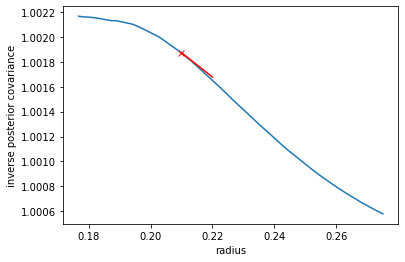

In [26]:
radius_test = 0.21  # choose value between 0.1767 and 0.275
flying_parameters_2 = flying_parameters.copy()
flying_parameters_2["radius"] = radius_test

drone_2 = Drone(fom, flying_parameters=flying_parameters_2, eval_mode=eval_mode, grid_t=grid_t)
brain_2 = Brain(fom=fom, drone=drone_2, prior=prior, noise_model=noise_model)
post_2 = brain_2.compute_posterior()
val = post_2.covar_inv[0, 0]

d_val = d_invPostCov_d_radius(flying_parameters=flying_parameters_2)


fig, ax = plt.subplots(1,1)

ax.plot(vec_radius, val_test)
ax.plot([radius_test, radius_test + 0.01], [val, val + 0.01 * d_val], color = "red")
ax.plot([radius_test], [val], marker = "x", color = "red")

ax.set_xlabel("radius")
ax.set_ylabel("inverse posterior covariance")

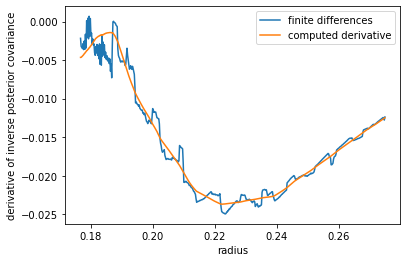

In [27]:
d_test = np.zeros((n_test-1,))
for i in range(n_test-1):
    flying_parameters_2 = flying_parameters.copy()
    flying_parameters_2["radius"] = vec_radius[i]
    d_test[i] = d_invPostCov_d_radius(flying_parameters=flying_parameters_2)

fig, ax = plt.subplots(1,1)

ax.plot(vec_radius[:-1], (val_test[1:]-val_test[:-1])/(vec_radius[1]-vec_radius[0]), label = 'finite differences')
ax.plot(vec_radius[:-1], d_test, label = 'computed derivative')

ax.set_xlabel("radius")
ax.set_ylabel("derivative of inverse posterior covariance")
ax.legend()

## The End.

In [28]:
print("Runtime of this notebook: {} min".format((time.time()-tStart_notebook)/60))

Runtime of this notebook: 2.710989550749461 min
